In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Old code for transforming the downloaded data into a csv
# df = pd.read_stata('Dlnet9198.dta')
# df.columns = ['Daytype', 'Workday', 'Half Hour', 'Gr, Fr, Dr, Ov', 'Gelderland', 'Utrecht', 'Noord-Holland', 'Zuid-Holland', 'Zeeland', 'Noord Brabant', 'Limburg', 'date', 'sem']
# df.to_csv('Dlnet1998.csv')

In [3]:
# Read the data and select columns
df = pd.read_excel('Dlnet1998.xlsx')
df = df[['Date2', 'Year', 'Month', 'Day', 'Daytype', 'Workday', 'Half Hour', 'Utrecht']]
df = df.rename(columns={'Utrecht': 'Load', 'Date2': 'Date'})

In [4]:
df = df[df['Year'] != 1998]

In [5]:
# Change column order
df1 = df[['Date', 'Half Hour', 'Year', 'Month', 'Day', 'Daytype', 'Workday', 'Load']]

In [6]:
# Convert loaddata from MWh/half hour to MW
df1['Load'] = df1['Load'] * 2

# Scale the data of Utrecht from 1991 to The Netherlands 2020

In [7]:
scale_factor = 17808 / 1441.142857142857 # Based on the maximum load in The Netherlands in the past 12 months at the moment of this research and the maximum average load in the data, which is calculated in the last cell of this script. The maximum load in The Netherlands can be retrieved from: https://www.tennet.eu/nl/elektriciteitsmarkt/data-dashboard/belasting/

In [8]:
df1['Load'] = df1['Load'] * scale_factor

# Fill missing values of time differences in March and drop leap days

In [9]:
# Fill missing values of time differences in March by taking the adjacent load as value for these missing times in March
for date in list(df1.Date.unique()):
    df_day = df1[df1['Date'] == date]
    if df_day.shape[0] != 48:        
        df_new = df1[df1['Date'] == date]
        df_new = df_new.reset_index(drop = True)
        df_new = df_new[3:5]
        df_new['Half Hour'] = [5, 6]
        df1 = df1.append(df_new)

df1 = df1.sort_values(['Year', 'Month', 'Day', 'Half Hour'])

In [10]:
# # Drop last days of 1992 and 1992 so every year has the same length. Leap days itself are not dropped intentionally to not lose a random weekday somewhere in the year
for i in range(1991,1998):
    if i%4 == 0:
        df2 = df1[df1['Year'] == i]
        df2 = df2[:17520]
        df1 = df1[df1['Year'] != i]
        df1 = df1.append(df2)
df1 = df1.sort_values(['Year', 'Month', 'Day', 'Half Hour'])
# ind = df1[(df1['Month'] == 2) & (df1['Day'] == 29)].index
# df1.drop(ind, inplace=True)
# df1 = df1.reset_index(drop = True)

# Add times

In [11]:
# Transform the data from half hour into 15 min blocks
df1 = df1.append(df1, ignore_index = True)
df1 = df1.sort_values(['Year', 'Month', 'Day', 'Half Hour'])
df1 = df1.reset_index(drop = True)

In [12]:
# For the new times, set the load the average of the two adjacent values
# The data of a half hour determines the value of times ending with 15 or 45. The time ending with 00 or 30 are the average between the cell above and below them.
for i in range(2, df1.shape[0], 2):
    df1.loc[i, 'Load'] = ((df1.loc[i-1, 'Load'] + df1.loc[i+1, 'Load']) / 2)

In [13]:
T = ['00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45', ]
T365 = T * 365
T2555 = T * 2555

In [14]:
df1['Time'] = T2555

# Drop irregular days

In [15]:
# Add old yearday
L = list(range(1, 366)) * 96
L.sort()
L = L * 7
df1['Old_Yearday'] = L

In [16]:
# Specify special days

# Truc is de leap days erin laten en dan dag 366 eruit zodat de weekdagen goed doorlopen --> in rapport

yeardict = {
    '1991': [88, 91, 120, 129, 130, 140],
    '1992': [108, 111, 121, 149, 150, 160],
    '1993': [99, 102, 120, 140, 141, 151],
    '1994': [91, 94, 120, 132, 133, 143],
    '1995': [104, 107, 120, 145, 146, 156],
    '1996': [96, 99, 121, 137, 138, 148],
    '1997': [87, 90, 120, 128, 129, 139],
}

In [17]:
# Convert special days into nans
for i in range(0, df1.shape[0], 96):
    for year in range(1991, 1998):
        if df1.loc[i, 'Year'] == year and df1.loc[i, 'Old_Yearday'] in yeardict[str(year)]:
            df1.loc[i:i+95, 'Load':'Load'] = 'nan'

In [18]:
special_days = [1, 125, 359, 360]
special_days_leap = [1, 126, 360, 361]

# Specify for every year how many days should be shifted
shiftdict = {
    '1991': 3,
    '1992': 2,
    '1993': 0,
    '1994': 6,
    '1995': 5,
    '1996': 4,
    '1997': 2
}

In [19]:
load1991 = df1[df1['Year'] == 1991]
load1992 = df1[df1['Year'] == 1992]
load1993 = df1[df1['Year'] == 1993]
load1994 = df1[df1['Year'] == 1994]
load1995 = df1[df1['Year'] == 1995]
load1996 = df1[df1['Year'] == 1996]
load1997 = df1[df1['Year'] == 1997]

In [20]:
## 1991
# Set the number of days that have to be shifted
shift = shiftdict['1991']

# Set Old_yearday - shift as new_yearday to make the shift possible
load1991['New Yearday'] = load1991['Old_Yearday'] - shift

# Make sure the special days keep their own place
for day in special_days:
    load1991.loc[load1991.Old_Yearday == day, 'New Yearday'] = day
    
# Use the first days of January (except for 1 January) that will fall of the dataframe after the shift to fill the gap that will arise in December because of the shift
for day in list(range(365))[2:2+shift]:
    load1991.loc[load1991.Old_Yearday == day, 'New Yearday'] = day + (52*7) - shift # Take shift number of days in january to fill the gap that will arise due to the shift

# The data that will be placed on a special day (except 1 January) is being put on the gap that arises because of the fact that these special days will not be moved. Since this data is from another weekday, this data is being replaced by nan values. Another option would be using data of another week, but this data is already been used at other days and therefore this would overrepresent this data.
# Note that the data of Yearday 1 + shift would normally also be pasted on 1 January, which is unwanted, but this has already been fixed above by moving the data to the end of December
for day in special_days[1:]:
    load1991.loc[load1991.Old_Yearday == day + shift, 'New Yearday'] = load1991['Old_Yearday'] - (2*shift)
    load1991.loc[load1991.Old_Yearday == day + shift, 'Load'] = 'nan'


## 1992
# Set the number of days that have to be shifted
shift = shiftdict['1992']

# Set Old_yearday - shift as new_yearday to make the shift possible
load1992['New Yearday'] = load1992['Old_Yearday'] - shift

# Make sure the special days keep their own place
for day in special_days_leap:
    load1992.loc[load1992.Old_Yearday == day, 'New Yearday'] = day
    
# Use the first days of January (except for 1 January) that will fall of the dataframe after the shift to fill the gap that will arise in December because of the shift
for day in list(range(365))[2:2+shift]:
    load1992.loc[load1992.Old_Yearday == day, 'New Yearday'] = day + (52*7) - shift # Take shift number of days in january to fill the gap that will arise due to the shift

# The data that will be placed on a special day (except 1 January) is being put on the gap that arises because of the fact that these special days will not be moved. Since this data is from another weekday, this data is being replaced by nan values. Another option would be using data of another week, but this data is already been used at other days and therefore this would overrepresent this data.
# Note that the data of Yearday 1 + shift would normally also be pasted on 1 January, which is unwanted, but this has already been fixed above by moving the data to the end of December
for day in special_days_leap[1:]:
    load1992.loc[load1992.Old_Yearday == day + shift, 'New Yearday'] = load1992['Old_Yearday'] - (2*shift)
    load1992.loc[load1992.Old_Yearday == day + shift, 'Load'] = 'nan'
    
# For the leap years, to align the data with the other years, swap the data from the special days after 29 February with the data from the day before. The data that goes the other way around is set to nan since its weekday is different from what is right at that place in the dataframe.
for day in special_days_leap[1:]:
    load1992.loc[load1992['New Yearday'] == day - 1, 'New Yearday'] = day + 1000
    load1992.loc[load1992['New Yearday'] == day, 'New Yearday'] = day - 1
    load1992.loc[load1992['New Yearday'] == day + 1000, 'New Yearday'] = day
    load1992.loc[load1992['New Yearday'] == day, 'Load'] = 'nan'

    
# Since 1993 is already starting on the right weekday, 1993 does not have to be shifted
load1993['New Yearday'] = load1993['Old_Yearday']


## 1994
# Set the number of days that have to be shifted
shift = shiftdict['1994']

# Set Old_yearday - shift as new_yearday to make the shift possible
load1994['New Yearday'] = load1994['Old_Yearday'] - shift

# Make sure the special days keep their own place
for day in special_days:
    load1994.loc[load1994.Old_Yearday == day, 'New Yearday'] = day
    
# Use the first days of January (except for 1 January) that will fall of the dataframe after the shift to fill the gap that will arise in December because of the shift
for day in list(range(365))[2:2+shift]:
    load1994.loc[load1994.Old_Yearday == day, 'New Yearday'] = day + (52*7) - shift # Take shift number of days in january to fill the gap that will arise due to the shift

# The data that will be placed on a special day (except 1 January) is being put on the gap that arises because of the fact that these special days will not be moved. Since this data is from another weekday, this data is being replaced by nan values. Another option would be using data of another week, but this data is already been used at other days and therefore this would overrepresent this data.
# Note that the data of Yearday 1 + shift would normally also be pasted on 1 January, which is unwanted, but this has already been fixed above by moving the data to the end of December
for day in special_days[1:]:
    load1994.loc[load1994.Old_Yearday == day + shift, 'New Yearday'] = load1994['Old_Yearday'] - (2*shift)
    load1994.loc[load1994.Old_Yearday == day + shift, 'Load'] = 'nan'

    
## 1995
# Set the number of days that have to be shifted
shift = shiftdict['1995']

# Set Old_yearday - shift as new_yearday to make the shift possible
load1995['New Yearday'] = load1995['Old_Yearday'] - shift

# Make sure the special days keep their own place
for day in special_days:
    load1995.loc[load1995.Old_Yearday == day, 'New Yearday'] = day
    
# Use the first days of January (except for 1 January) that will fall of the dataframe after the shift to fill the gap that will arise in December because of the shift
for day in list(range(365))[2:2+shift]:
    load1995.loc[load1995.Old_Yearday == day, 'New Yearday'] = day + (52*7) - shift # Take shift number of days in january to fill the gap that will arise due to the shift

# The data that will be placed on a special day (except 1 January) is being put on the gap that arises because of the fact that these special days will not be moved. Since this data is from another weekday, this data is being replaced by nan values. Another option would be using data of another week, but this data is already been used at other days and therefore this would overrepresent this data.
# Note that the data of Yearday 1 + shift would normally also be pasted on 1 January, which is unwanted, but this has already been fixed above by moving the data to the end of December
for day in special_days[1:]:
    load1995.loc[load1995.Old_Yearday == day + shift, 'New Yearday'] = load1995['Old_Yearday'] - (2*shift)
    load1995.loc[load1995.Old_Yearday == day + shift, 'Load'] = 'nan'


## 1996
# Set the number of days that have to be shifted
shift = shiftdict['1996']

# Set Old_yearday - shift as new_yearday to make the shift possible
load1996['New Yearday'] = load1996['Old_Yearday'] - shift

# Make sure the special days keep their own place
for day in special_days_leap:
    load1996.loc[load1996.Old_Yearday == day, 'New Yearday'] = day
    
# Use the first days of January (except for 1 January) that will fall of the dataframe after the shift to fill the gap that will arise in December because of the shift
for day in list(range(365))[2:2+shift]:
    load1996.loc[load1996.Old_Yearday == day, 'New Yearday'] = day + (52*7) - shift # Take shift number of days in january to fill the gap that will arise due to the shift

# The data that will be placed on a special day (except 1 January) is being put on the gap that arises because of the fact that these special days will not be moved. Since this data is from another weekday, this data is being replaced by nan values. Another option would be using data of another week, but this data is already been used at other days and therefore this would overrepresent this data.
# Note that the data of Yearday 1 + shift would normally also be pasted on 1 January, which is unwanted, but this has already been fixed above by moving the data to the end of December
for day in special_days_leap[1:]:
    load1996.loc[load1996.Old_Yearday == day + shift, 'New Yearday'] = load1996['Old_Yearday'] - (2*shift)
    load1996.loc[load1996.Old_Yearday == day + shift, 'Load'] = 'nan'
    
# For the leap years, to align the data with the other years, swap the data from the special days after 29 February with the data from the day before. The data that goes the other way around is set to nan since its weekday is different from what is right at that place in the dataframe.
for day in special_days_leap[1:]:
    load1996.loc[load1996['New Yearday'] == day - 1, 'New Yearday'] = day + 1000
    load1996.loc[load1996['New Yearday'] == day, 'New Yearday'] = day - 1
    load1996.loc[load1996['New Yearday'] == day + 1000, 'New Yearday'] = day
    load1996.loc[load1996['New Yearday'] == day, 'Load'] = 'nan'

    
## 1997
# Set the number of days that have to be shifted
shift = shiftdict['1997']

# Set Old_yearday - shift as new_yearday to make the shift possible
load1997['New Yearday'] = load1997['Old_Yearday'] - shift

# Make sure the special days keep their own place
for day in special_days:
    load1997.loc[load1997.Old_Yearday == day, 'New Yearday'] = day
    
# Use the first days of January (except for 1 January) that will fall of the dataframe after the shift to fill the gap that will arise in December because of the shift
for day in list(range(365))[2:2+shift]:
    load1997.loc[load1997.Old_Yearday == day, 'New Yearday'] = day + (52*7) - shift # Take shift number of days in january to fill the gap that will arise due to the shift

# The data that will be placed on a special day (except 1 January) is being put on the gap that arises because of the fact that these special days will not be moved. Since this data is from another weekday, this data is being replaced by nan values. Another option would be using data of another week, but this data is already been used at other days and therefore this would overrepresent this data.
# Note that the data of Yearday 1 + shift would normally also be pasted on 1 January, which is unwanted, but this has already been fixed above by moving the data to the end of December
for day in special_days[1:]:
    load1997.loc[load1997.Old_Yearday == day + shift, 'New Yearday'] = load1997['Old_Yearday'] - (2*shift)
    load1997.loc[load1997.Old_Yearday == day + shift, 'Load'] = 'nan'


C:\Users\sjoer\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sjoer\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\sjoer\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [21]:
# Make the shift and rename columns
load1991 = load1991.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)
load1992 = load1992.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)
load1993 = load1993.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)
load1994 = load1994.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)
load1995 = load1995.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)
load1996 = load1996.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)
load1997 = load1997.sort_values(['New Yearday', 'Time']).reset_index(drop = True).rename(columns={'New Yearday': 'Yearday'}).drop(['Old_Yearday'], axis = 1)

# Make a dataframe with average load data

In [22]:
list_df = [load1991, load1992, load1993, load1994, load1995, load1996, load1997]

In [23]:
average_load = pd.DataFrame(index = range(35040), columns = ['Yearday', 'Workday', 'Weekday', 'Time', 'Load [MW]'])
for c in ['Yearday', 'Time']:
    average_load[c] = load1991[c]
    
# Add Workday column
average_load['Workday'] = True

# Set workday False in the weekends
average_load.loc[load1991.Daytype == 1, 'Workday'] = False
average_load.loc[load1991.Daytype == 7, 'Workday'] = False
    
# Set workday False at special day: New Year's Day, Liberation Day, Christmas
average_load.loc[average_load.Yearday == 1, 'Workday'] = False
average_load.loc[average_load.Yearday == 125, 'Workday'] = False
average_load.loc[average_load.Yearday == 359, 'Workday'] = False
average_load.loc[average_load.Yearday == 360, 'Workday'] = False

average_load['Weekday'] = load1993['Daytype']

# Add average load
for t in range(35040):
    L = []
    for d in list_df:
        L.append(d.loc[t, 'Load'])
    L1 = [x for x in L if str(x) != 'nan']
    average_load.loc[t, 'Load [MW]'] = sum(L1) / len(L1)

# Save data

In [24]:
df1 = df1[['Date', 'Year' ,'Month', 'Day', 'Daytype', 'Workday', 'Time', 'Load']]

In [25]:
# Save load data for every year
for year in range(1991, 1998):
    df_year = df1[df1['Year'] == year]
    df_year = df_year.reset_index(drop = True)
    df_year.to_csv('Loaddata ' + str(year) + '.csv')

In [26]:
# Save average load data
average_load.to_csv('Loaddata average.csv')

In [27]:
average_load[28:41]

,Yearday,Workday,Weekday,Time,Load [MW]
28,1,False,6,07:00,6635.63
29,1,False,6,07:15,6768.03
30,1,False,6,07:30,6941.02
31,1,False,6,07:45,7114.02
32,1,False,6,08:00,7272.89
33,1,False,6,08:15,7431.77
34,1,False,6,08:30,7495.32
35,1,False,6,08:45,7558.87
36,1,False,6,09:00,7677.14
37,1,False,6,09:15,7795.41


# Save plots for workday and weekday

In [28]:
df_work = pd.DataFrame(0, index = range(96), columns = ['Time', 'Load [MW]'])
df_weekend = pd.DataFrame(0, index = range(96), columns = ['Time', 'Load [MW]'])

for i in range(96):
    work = average_load[average_load['Workday'] == True]
    weekend = average_load[average_load['Workday'] == False]
    
    work2 = work[work.index % 96 == i]
    weekend2 = weekend[weekend.index % 96 == i]
    
    average_load_work = work2['Load [MW]'].sum() / work2.shape[0]
    average_load_weekend = weekend2['Load [MW]'].sum() / weekend2.shape[0]
    
    df_work.loc[i, 'Load [MW]'] = average_load_work
    df_weekend.loc[i, 'Load [MW]'] = average_load_weekend

df_work['Time'] = T
df_weekend['Time'] = T

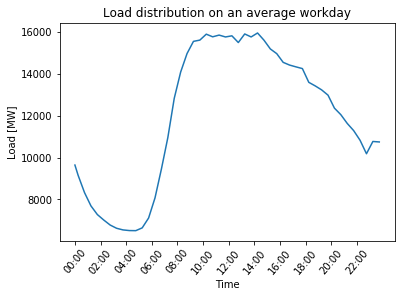

In [30]:
x = df_work['Time']
y1 = df_work['Load [MW]']
plt.plot(x, y1)
plt.xticks(np.arange(0, 96, 8), rotation = 50)
plt.xlabel('Time') 
plt.ylabel('Load [MW]') 
plt.title('Load distribution on an average workday') 
plt.savefig('Load distribution on an average workday.png')
plt.show() 

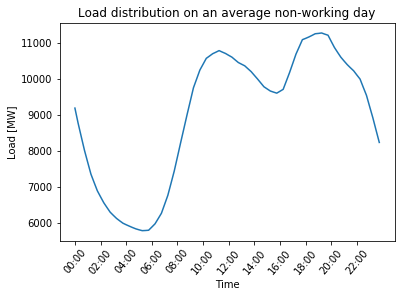

In [29]:
x = df_weekend['Time']
y2 = df_weekend['Load [MW]']
plt.plot(x, y2)
plt.xticks(np.arange(0, 96, 8), rotation = 50)
plt.xlabel('Time') 
plt.ylabel('Load [MW]') 
plt.title('Load distribution on an average non-working day') 
plt.savefig('Load distribution on an average non-working day.png')
plt.show() 

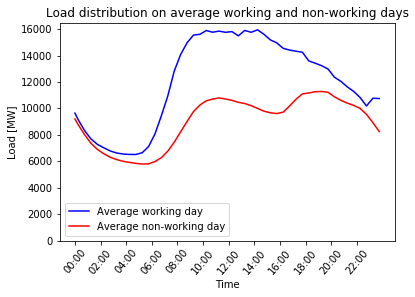

In [43]:
x = df_weekend['Time']
y1 = df_work['Load [MW]']
y2 = df_weekend['Load [MW]']
plt.plot(x, y1, color = 'blue', label = 'Average working day')
plt.plot(x, y2, color = 'red', label = 'Average non-working day')
plt.xticks(np.arange(0, 96, 8), rotation = 50)
plt.yticks(np.arange(0, 16001, 2000))
plt.xlabel('Time') 
plt.ylabel('Load [MW]') 
plt.title('Load distribution on average working and non-working days')
plt.legend()
plt.savefig('Load distribution on average working and non-working days')
plt.show() 

# Estimate maximum load

This only has been used after running the code without using the scale factor. The maximum of the average load (1441.142857142857) serves as input to the scale factor. After that, the code is run again to save the results.

In [31]:
max(list(average_load['Load [MW]']))

17808.000000000004